In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import sklearn.metrics as m
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

hello
hello
hello
   ID  Q_Age  Q_Gender  Q_City  Q1  Q4  Q7  Q13_1  Q13_2  Q13_3  ...  Q27_5  \
0  18     71         1       4   2   3   3      1      1      0  ...      0   
1  23     65         2       5   1   1   2      1      0      0  ...      0   
2  30     77         1       4   1   1   2      0      0      1  ...      0   
3  31     75         1       4   2   3   3      0      0      1  ...      0   
4  34     73         2       4   1   2   2      1      0      0  ...      0   

   Q27_6  Q27_7  Q27_8  Q27_9  Q27_10  Q28  Q29  Q32  Percentage_Change  
0      0      0      0      0       0    4    2    3         -58.789523  
1      0      0      0      0       0    1    2    1         -22.622194  
2      0      1      0      0       0    4    2    1         -82.803087  
3      0      1      0      0       0    4    2    2          -8.944713  
4      0      1      0      0       0    4    2    6         -16.702032  

[5 rows x 42 columns]
(1114, 42)


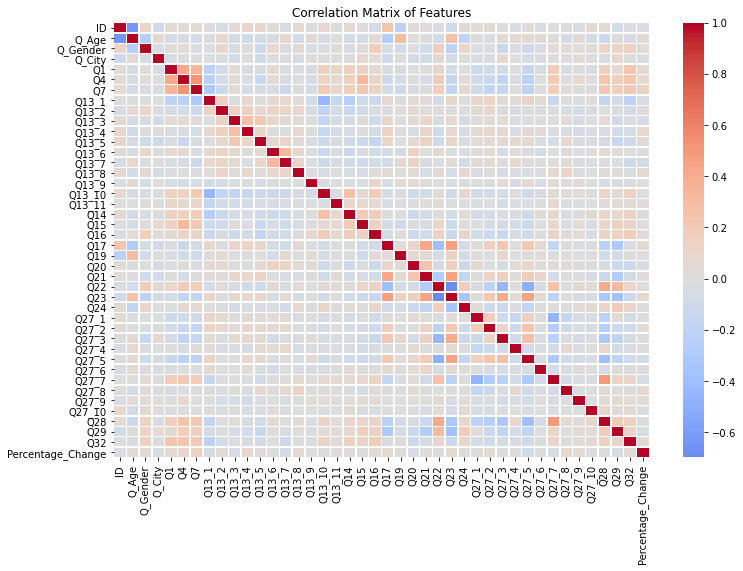

Top 20 correlating feature pairs (|r| < 1):
Feature1 Feature2  Correlation
     Q23      Q22    -0.698299
   Q_Age       ID    -0.640379
      Q7       Q4     0.522105
   Q27_5      Q22    -0.500542
     Q28    Q27_7     0.491505
   Q27_7    Q27_1    -0.465017
     Q23      Q17     0.464293
   Q27_3      Q22    -0.450823
     Q23      Q21     0.446400
   Q27_5      Q23     0.445724
  Q13_10    Q13_1    -0.442565
     Q21      Q17     0.426357
      Q4       Q1     0.417117
   Q27_3      Q23     0.407948
     Q28      Q22     0.405001
     Q22      Q17    -0.389376
     Q28    Q27_5    -0.388579
     Q29      Q23    -0.373811
      Q7       Q1     0.344709
     Q24      Q23    -0.343776


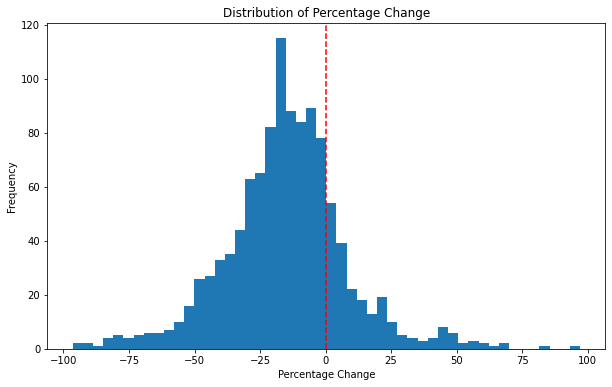

Lower threshold (33rd percentile): -22.7255
Upper threshold (67th percentile): -6.8939
Counts of each class:
0.0    368
1.0    368
Name: is_price_responsive, dtype: int64
Class proportions:
0.0    50.0
1.0    50.0
Name: is_price_responsive, dtype: float64
Features (X): ['Q_Age', 'Q_Gender', 'Q_City', 'Q1', 'Q4', 'Q7', 'Q13_1', 'Q13_2', 'Q13_3', 'Q13_4', 'Q13_5', 'Q13_6', 'Q13_7', 'Q13_8', 'Q13_9', 'Q13_10', 'Q13_11', 'Q14', 'Q15', 'Q16', 'Q17', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q27_1', 'Q27_2', 'Q27_3', 'Q27_4', 'Q27_5', 'Q27_6', 'Q27_7', 'Q27_8', 'Q27_9', 'Q27_10', 'Q28', 'Q29', 'Q32']
Target (y): is_price_responsive
Variance Inflation Factors (before feature engineering):
     Feature        VIF
22       Q20  30.659521
25       Q23  25.335658
0      Q_Age  20.852800
38       Q29  19.601910
2     Q_City  16.971005
24       Q22  15.522219
5         Q7  14.459106
3         Q1  14.138427
26       Q24  13.957788
19       Q16  12.843899
1   Q_Gender  10.977630
23       Q21  10.493

In [18]:
print('hello')
print('hello')
print('hello')

# Load the data
df = pd.read_csv('survey_PE12345.csv')  # Using the new merged file
print(df.head())
print(df.shape)

#-------------------------------------------------------CORRELATION MATRIX------------------------------------------------------
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot=False, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()

# Find highly correlated feature pairs
upper_triangle = np.triu(np.ones_like(corr_matrix, dtype=bool))
high_corr_pairs = (corr_matrix.where(~upper_triangle)
                  .stack()
                  .reset_index()
                  .rename(columns={'level_0':'Feature1', 'level_1':'Feature2', 0:'Correlation'}))
high_corr_pairs = (high_corr_pairs[abs(high_corr_pairs['Correlation']) < 1]
                  .sort_values(by='Correlation', key=abs, ascending=False))
top_n = 20
print(f"Top {top_n} correlating feature pairs (|r| < 1):")
print(high_corr_pairs.head(top_n).to_string(index=False))

#-------------------------------------------------------MAKE TO CLASSIFICATION PROBLEM----------------------------------------------------
# Calculate appropriate thresholds based on the Percentage_Change data
# We're using similar logic but with Percentage_Change instead of Price_elasticity

# First, let's look at the distribution of Percentage_Change
plt.figure(figsize=(10, 6))
plt.hist(df['Percentage_Change'], bins=50)
plt.title("Distribution of Percentage Change")
plt.xlabel("Percentage Change")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.show()

# Calculate thresholds based on percentiles or absolute values
# Using percentiles as an example (adjust as needed)
lower_threshold = df['Percentage_Change'].quantile(0.33)  # Bottom third
upper_threshold = df['Percentage_Change'].quantile(0.67)  # Top third

print(f"Lower threshold (33rd percentile): {lower_threshold:.4f}")
print(f"Upper threshold (67th percentile): {upper_threshold:.4f}")

# Alternative: Use fixed values around zero
# lower_threshold = -3.0  # 3% decrease
# upper_threshold = 3.0   # 3% increase

# Create classification variable based on percentage change
df['is_price_responsive'] = df['Percentage_Change'].apply(
    lambda x: 1 if x < lower_threshold else (0 if x > upper_threshold else None)
)

# Drop rows that fall between thresholds (neither responsive nor unresponsive)
df = df.dropna(subset=['is_price_responsive'])

# Check class distribution
counts = df['is_price_responsive'].value_counts()
print("Counts of each class:")
print(counts)

# Print proportions
proportions = counts / counts.sum() * 100
print("Class proportions:")
print(proportions)

# Prepare features and target
X = df.drop(columns=["is_price_responsive", "Percentage_Change", 'ID'])
y = df['is_price_responsive']

print("Features (X):", list(X.columns)) 
print("Target (y):", y.name)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

#-------------------------------------------------- Calculate VIF for each feature
# Check for multicollinearity
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print("Variance Inflation Factors (before feature engineering):")
print(vif_data.sort_values("VIF", ascending=False))

#-------------------------------------------------------FEATURE ENGINEERING----------------------------------------------------
# Check if Q22 and Q23 exist in the dataset before trying to transform them
if 'Q22' in X_train.columns and 'Q23' in X_train.columns:
    X_train['Q22_x_Q23'] = X_train['Q22'] * X_train['Q23']
    X_train = X_train.drop(columns=['Q22', 'Q23'])
    
    X_test['Q22_x_Q23'] = X_test['Q22'] * X_test['Q23']
    X_test = X_test.drop(columns=['Q22', 'Q23'])
    
    print("Feature engineering completed: Created Q22_x_Q23 interaction term")
else:
    print("Warning: Q22 and/or Q23 not found in the dataset. Skipping this feature engineering step.")

print("Training features:", X_train.columns.tolist())
print("Test features:", X_test.columns.tolist())

#-------------------------------------------------- Calculate VIF again after feature engineering
if len(X_train.columns) > 0:  # Make sure we have features left
    vif_data1 = pd.DataFrame()
    vif_data1["Feature"] = X_train.columns
    vif_data1["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    print("Variance Inflation Factors (after feature engineering):")
    print(vif_data1.sort_values("VIF", ascending=False))
else:
    print("No features available for VIF calculation after feature engineering")

Accuracy: 0.6121975952484427
['Q_City', 'Q4', 'Q7', 'Q13_8', 'Q13_9', 'Q13_11', 'Q14', 'Q16', 'Q17', 'Q21', 'Q27_3', 'Q27_7', 'Q27_8', 'Q27_9', 'Q27_10']


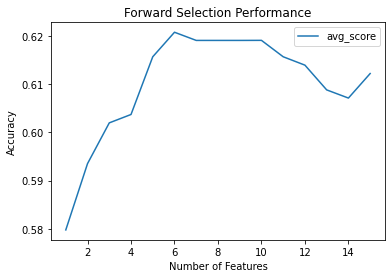

Top 20 Features with TRUE Fisher Scores:
   Feature  Fisher_Score  Percentile
5       Q7      0.033555       100.0
4       Q4      0.018979        97.0
3       Q1      0.010219        95.0
12   Q13_7      0.007923        92.0
0    Q_Age      0.007360        90.0
2   Q_City      0.006455        87.0
33   Q27_9      0.006009        85.0
29   Q27_5      0.005602        82.0
28   Q27_4      0.005464        79.0
36     Q29      0.004402        77.0
9    Q13_4      0.004274        74.0
6    Q13_1      0.004231        72.0
26   Q27_2      0.002916        69.0
31   Q27_7      0.002760        67.0
13   Q13_8      0.002741        64.0
30   Q27_6      0.002502        62.0
22     Q20      0.002278        59.0
27   Q27_3      0.001963        56.0
34  Q27_10      0.001742        54.0
15  Q13_10      0.001700        51.0
Significant Features by Chi-Squared Test (p < 0.05):
      Feature  Chi2_Score   p_value
4          Q4    8.026185  0.004611
5          Q7    4.620288  0.031596
12      Q13_7    3.89

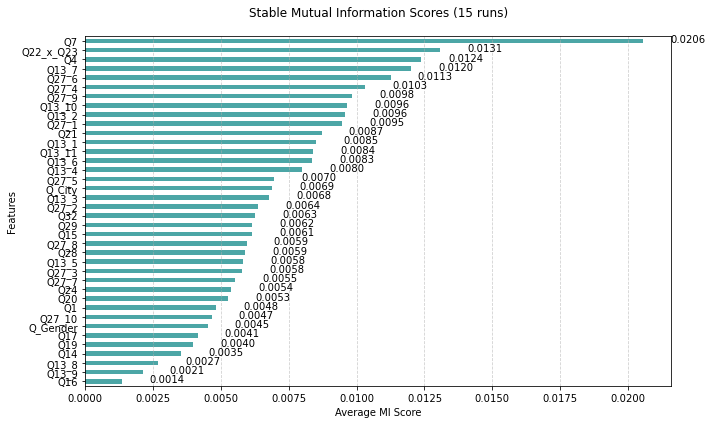

<Figure size 864x576 with 0 Axes>

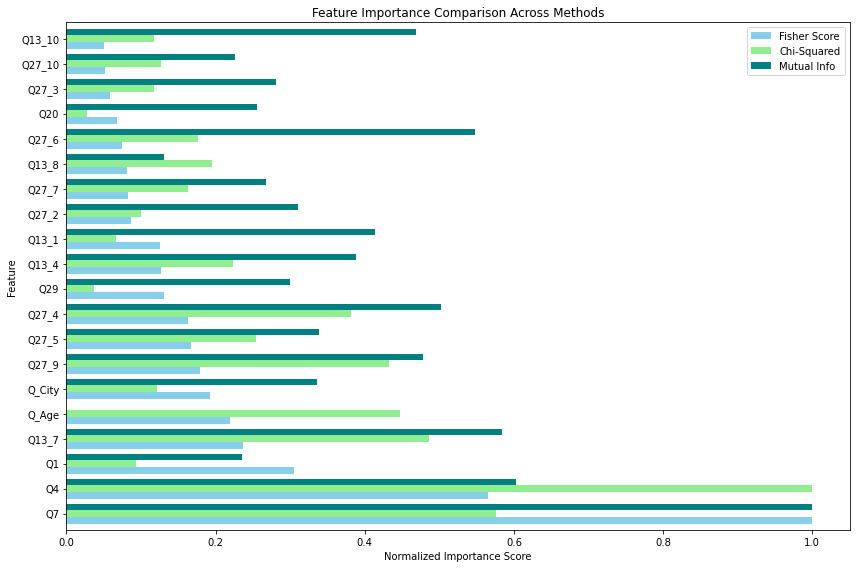


Top 20 Features by Stable Mutual Information:
      Feature  IG_Score  IG_Variance  IG_Percentile
4          Q7    0.0206       0.0130       100.0000
37  Q22_x_Q23    0.0131       0.0099        97.4000
3          Q4    0.0124       0.0153        94.7000
11      Q13_7    0.0120       0.0106        92.1000
29      Q27_6    0.0113       0.0124        89.5000
27      Q27_4    0.0103       0.0093        86.8000
32      Q27_9    0.0098       0.0118        84.2000
14     Q13_10    0.0096       0.0108        81.6000
6       Q13_2    0.0096       0.0094        78.9000
24      Q27_1    0.0095       0.0137        76.3000
22        Q21    0.0087       0.0140        73.7000
5       Q13_1    0.0085       0.0097        71.1000
15     Q13_11    0.0084       0.0127        68.4000
10      Q13_6    0.0083       0.0097        65.8000
8       Q13_4    0.0080       0.0077        63.2000
28      Q27_5    0.0070       0.0113        60.5000
1      Q_City    0.0069       0.0091        57.9000
7       Q13_3    

In [19]:
#--------------------------------------------------FEATURE SCALING ---------------------------------------------
#FOR LINEAR MODELS

# Scale and keep column names
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),  # This converts to NumPy array
    columns=X_train.columns         # Reattach column names
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

#---------------------------------------------------------FORWARD SELECTION-----------------------------------------------------


model = LogisticRegression(max_iter=10000, solver='saga', C=0.1,class_weight='balanced')

sfs = SFS(model, k_features=15, forward=True, floating=False, scoring="accuracy", cv=5)

sfs.fit(X_train_scaled, y_train)

selected_features = list(sfs.k_feature_names_)

X_train_top15 = X_train_scaled[selected_features]
X_test_top15 = X_test_scaled[selected_features]

#print("Selected Features:", sfs.k_feature_names_)

accuracy = sfs.k_score_
print("Accuracy:", accuracy)

print(selected_features)

sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df["avg_score"] = sfs_df["avg_score"].astype(float)
fig, ax = plt.subplots()
sfs_df.plot(kind="line", y="avg_score", ax=ax)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title("Forward Selection Performance")
plt.show()

#-----------------------------------------------------------FISHER SCORE-------------------------------------------------------

def manual_fisher_score(X, y):
    """
    Compute true Fisher Scores (not ranks) for features.
    Returns continuous values where higher = more important.
    """
    X = np.array(X)
    y = np.array(y)
    classes = np.unique(y)
    scores = []
    
    for feature in X.T:  # Loop through each feature
        overall_mean = np.mean(feature)
        
        # Between-class variance (numerator)
        between_var = sum(
            [np.sum(y == cls) * (np.mean(feature[y == cls]) - overall_mean)**2 
            for cls in classes])
        
        # Within-class variance (denominator)
        within_var = sum([np.var(feature[y == cls]) * np.sum(y == cls) for cls in classes])
        
        # Avoid division by zero
        fisher_score = between_var / (within_var + 1e-9)
        scores.append(fisher_score)
    
    return np.array(scores)

# Usage:
ranks = manual_fisher_score(X_train_scaled, y_train)

# Create DataFrame with TRUE Fisher Scores
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,  # Use scaled DataFrame's columns
    'Fisher_Score': ranks
}).sort_values('Fisher_Score', ascending=False)

# Add percentile rank to show relative importance
feature_importance['Percentile'] = (
    feature_importance['Fisher_Score'].rank(pct=True).round(2) * 100
)

print("Top 20 Features with TRUE Fisher Scores:")
print(feature_importance.head(20))
#-----------------------------------------------------------CHI SQUARED-------------------------------------------------------

from sklearn.feature_selection import chi2
from sklearn.preprocessing import KBinsDiscretizer

X_train_chi2 = X_train.copy()

discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
X_train_chi2['Q_Age'] = discretizer.fit_transform(X_train_chi2[['Q_Age']])

# Convert all data to integers (chi2 requires non-negative)
X_train_chi2 = X_train_chi2.astype(int)

# 2. Perform Chi-Squared Test
# --------------------------
chi_scores, p_values = chi2(X_train_chi2, y_train)

# Create results DataFrame
chi2_results = pd.DataFrame({
    'Feature': X_train.columns,
    'Chi2_Score': chi_scores,
    'p_value': p_values
}).sort_values('Chi2_Score', ascending=False)

# Filter significant features (p-value < 0.05)
significant_features = chi2_results[chi2_results['p_value'] < 0.4]
print("Significant Features by Chi-Squared Test (p < 0.05):")
print(significant_features)

#---------------------------------------------------------INFORMATION GAIN-----------------------------------------------------

from sklearn.feature_selection import mutual_info_classif
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# [Keep your existing Fisher Score and Chi-Squared code here]

# =============================================
# Stable Mutual Information Computation
# =============================================
def compute_stable_mi(X, y, n_runs=15, n_neighbors=5, random_state=42):
    """Compute stable mutual information scores with multiple runs"""
    mi_scores = np.zeros((n_runs, X.shape[1]))
    
    for i in range(n_runs):
        mi_scores[i] = mutual_info_classif(
            X, y,
            n_neighbors=n_neighbors,
            random_state=random_state + i
        )
    
    mean_scores = mi_scores.mean(axis=0)
    valid_idx = mean_scores > 0.001
    return (
        pd.Series(mean_scores[valid_idx], index=X.columns[valid_idx]),
        mi_scores.std(axis=0)[valid_idx],
        valid_idx
    )

# Compute stable MI
stable_mi, mi_std, valid_idx = compute_stable_mi(X_train, y_train)

# Store results
ig_results = pd.DataFrame({
    'Feature': X_train.columns[valid_idx],
    'IG_Score': stable_mi.values,
    'IG_Variance': mi_std
}).sort_values('IG_Score', ascending=False)

ig_results['IG_Percentile'] = (ig_results['IG_Score'].rank(pct=True).round(3) * 100)

# =============================================
# Visualization - Stable MI
# =============================================
plt.figure(figsize=(10, 6))
ax = stable_mi.sort_values().plot(kind='barh', color='teal', alpha=0.7)

for i in ax.patches:
    ax.text(i.get_width() + 0.001, i.get_y() + 0.1,
            f'{i.get_width():.4f}', fontsize=10)

plt.title('Stable Mutual Information Scores (15 runs)', pad=20)
plt.xlabel('Average MI Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# =============================================
# Combine All Results
# =============================================
combined_results = (
    feature_importance
    .merge(chi2_results[['Feature', 'Chi2_Score', 'p_value']], on='Feature', how='left')
    .merge(ig_results, on='Feature', how='left')
)

# Fill NA for features not present in all methods
combined_results.fillna({'IG_Score': 0, 'IG_Percentile': 0, 'IG_Variance': 0}, inplace=True)

# =============================================
# Tri-Method Comparison (Fixed)
# =============================================
plt.figure(figsize=(12, 8))
top_n = min(20, len(combined_results))
top_features = combined_results.nlargest(top_n, 'Fisher_Score').copy()

# Create normalized scores
top_features['Fisher_norm'] = top_features['Fisher_Score'] / top_features['Fisher_Score'].max()
top_features['Chi2_norm'] = top_features['Chi2_Score'] / top_features['Chi2_Score'].max()
top_features['IG_norm'] = top_features['IG_Score'] / top_features['IG_Score'].max()

# Plot with proper column names
plot_data = top_features.set_index('Feature')[['Fisher_norm', 'Chi2_norm', 'IG_norm']]
plot_data.plot(
    kind='barh',
    color=['skyblue', 'lightgreen', 'teal'],
    width=0.8,
    figsize=(12,8)
)

plt.title('Feature Importance Comparison Across Methods')
plt.xlabel('Normalized Importance Score')
plt.ylabel('Feature')
plt.legend(['Fisher Score', 'Chi-Squared', 'Mutual Info'])
plt.tight_layout()
plt.show()

# =============================================
# Final Output
# =============================================
print("\nTop 20 Features by Stable Mutual Information:")
print(ig_results.head(20).to_string(float_format="%.4f"))

print("\nConsensus Features (Important in All Methods):")
consensus = combined_results[
    (combined_results['Percentile'] > 60) & 
    (combined_results['p_value'] < 0.4) &
    (combined_results['IG_Percentile'] > 60)
]
print(consensus[['Feature', 'Fisher_Score', 'Chi2_Score', 'IG_Score']].to_string(float_format="%.4f"))

# =============================================
# Logistic Regression with Selected Features
# =============================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Get top consensus features
selected_features = consensus['Feature'].tolist()

top_fisher = feature_importance.head(5)['Feature'].tolist()          # Top 5 Fisher
top_chi2 = chi2_results[chi2_results['p_value'] < 0.05].head(5)['Feature'].tolist()  # Top 5 Chi2
top_ig = ig_results.head(5)['Feature'].tolist()                     # Top 5 IG

combined_features = list(set(top_fisher + top_chi2 + top_ig))  # Unique union
print("Combined Top Features:", combined_features)

if len(selected_features) > 0:
    print("\nTraining Logistic Regression on selected features...")
    model = LogisticRegression(max_iter=100000, solver='saga', C=0.01, class_weight='balanced')
    model.fit(X_train_scaled[selected_features], y_train)
    
    print("\nClassification Report:")
    print(classification_report(y_test, model.predict(X_test_scaled[selected_features])))
else:
    print("\nNo consensus features found. Using top Fisher features instead.")
    selected_features = feature_importance.head(10)['Feature'].tolist()
    model = LogisticRegression(max_iter=100000, solver='saga', C=0.01, class_weight='balanced')
    model.fit(X_train_scaled[selected_features], y_train)
    
    print("\nClassification Report (Top 10 Fisher Features):")
    print(classification_report(y_test, model.predict(X_test_scaled[selected_features])))
    
from sklearn.metrics import f1_score

def test_features(features):
    model = LogisticRegression(max_iter=10000, class_weight='balanced')
    model.fit(X_train_scaled[features], y_train)
    pred = model.predict(X_test_scaled[features])
    print(f"Features: {len(features)}, F1: {f1_score(y_test, pred):.3f}")

# Test different sets
test_features(selected_features)               # Original 3 features
test_features(combined_features)               # Top from each method
test_features(selected_features + ['Q14'])    # Add Q14 (high Fisher)


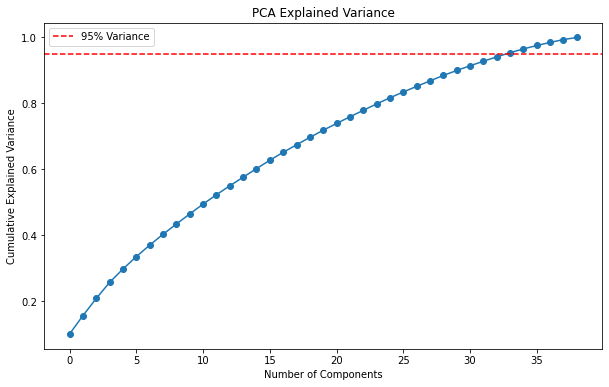

Components needed for 95% variance: 34


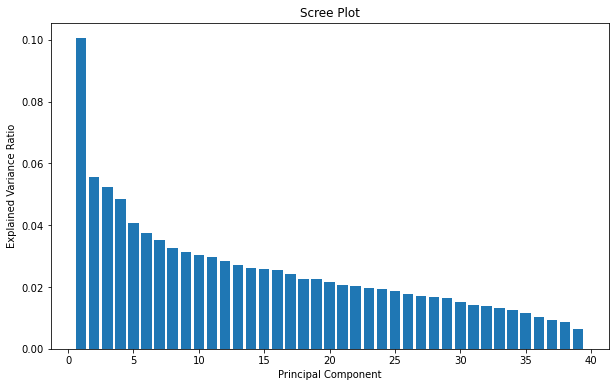


Top features for PC1:
Q28      0.299908
Q4       0.295786
Q7       0.284075
Q27_5    0.270979
Q27_7    0.259887
Name: PC1, dtype: float64

Top features for PC2:
Q13_6     0.336146
Q13_7     0.300554
Q14       0.295886
Q13_10    0.271945
Q28       0.240790
Name: PC2, dtype: float64

Top features for PC3:
Q21    0.419532
Q29    0.308238
Q24    0.299657
Q20    0.272129
Q1     0.267534
Name: PC3, dtype: float64

Top features for PC4:
Q_Age       0.491820
Q13_4       0.357606
Q13_3       0.299694
Q17         0.290031
Q_Gender    0.247984
Name: PC4, dtype: float64

Top features for PC5:
Q27_1    0.395874
Q15      0.310305
Q4       0.291135
Q27_2    0.270174
Q27_4    0.259336
Name: PC5, dtype: float64

Top features for PC6:
Q19      0.373740
Q13_6    0.302843
Q20      0.301264
Q13_2    0.287560
Q13_7    0.256277
Name: PC6, dtype: float64

Top features for PC7:
Q27_3    0.354478
Q27_6    0.307633
Q21      0.295585
Q13_3    0.255173
Q20      0.243161
Name: PC7, dtype: float64

Top features for

In [20]:
#Domain features 


selected_features = ['Q4', 'Q7', 'Q13_5', 'Q16', 'Q17', 'Q20', 
                    'Q21', 'Q22_x_Q23', 'Q27_5', 'Q29']

X_train_domain = X_train_scaled[selected_features].copy() 
X_test_domain = X_test_scaled[selected_features].copy()


from sklearn.decomposition import PCA

# Initialize PCA (keep all components initially)
pca = PCA()
X_pca = pca.fit_transform(X_train_scaled)  # Fit and transform in one step

import matplotlib.pyplot as plt
import numpy as np

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.show()

# Choose components explaining ≥95% variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Components needed for 95% variance: {n_components}")

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

# Refit PCA with optimal components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train_scaled)

# Create a DataFrame of loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=X_train.columns  # Original feature names
)

# Show top 5 features per PC
for pc in loadings.columns:
    print(f"\nTop features for {pc}:")
    print(loadings[pc].abs().sort_values(ascending=False).head(5))
    
# 1. Fit PCA on TRAINING data only (avoid data leakage)
pca = PCA(n_components=n_components)  # Use your chosen n_components
X_train_pca = pca.fit_transform(X_train_scaled)  # Fit and transform training data

# 2. Transform TEST data using the same PCA
X_test_pca = pca.transform(X_test_scaled)  # Only transform, don't fit!

# 3. Convert to DataFrames with proper naming
X_train_pca = pd.DataFrame(
    X_train_pca,
    columns=[f"PC{i+1}" for i in range(n_components)],
    index=X_train_scaled.index  # Preserve original indices
)

X_test_pca = pd.DataFrame(
    X_test_pca,
    columns=[f"PC{i+1}" for i in range(n_components)],
    index=X_test_scaled.index
)

Logistic Regression Results:
Accuracy: 0.5676
Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.55      0.55        71
         1.0       0.58      0.58      0.58        77

    accuracy                           0.57       148
   macro avg       0.57      0.57      0.57       148
weighted avg       0.57      0.57      0.57       148

Confusion Matrix:
[[39 32]
 [32 45]]


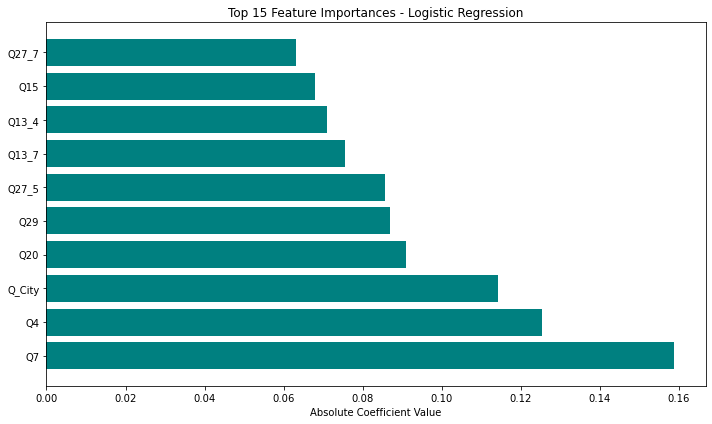

Logistic Regression Results:
Accuracy: 0.5676
Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.56      0.56        71
         1.0       0.59      0.57      0.58        77

    accuracy                           0.57       148
   macro avg       0.57      0.57      0.57       148
weighted avg       0.57      0.57      0.57       148

Confusion Matrix:
[[40 31]
 [33 44]]


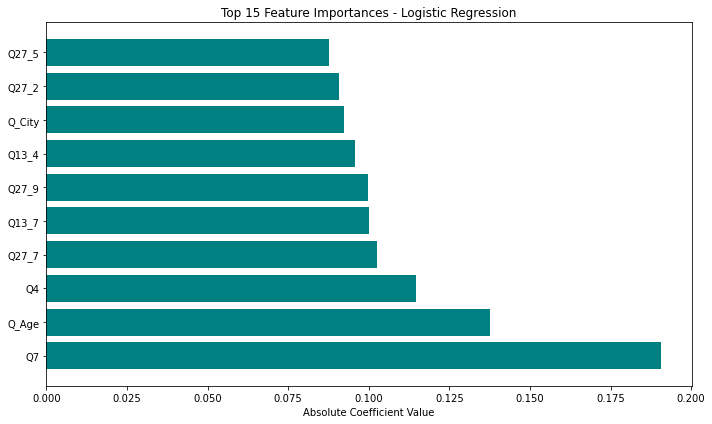

Logistic Regression Results:
Accuracy: 0.5743
Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.56      0.56        71
         1.0       0.59      0.58      0.59        77

    accuracy                           0.57       148
   macro avg       0.57      0.57      0.57       148
weighted avg       0.57      0.57      0.57       148

Confusion Matrix:
[[40 31]
 [32 45]]


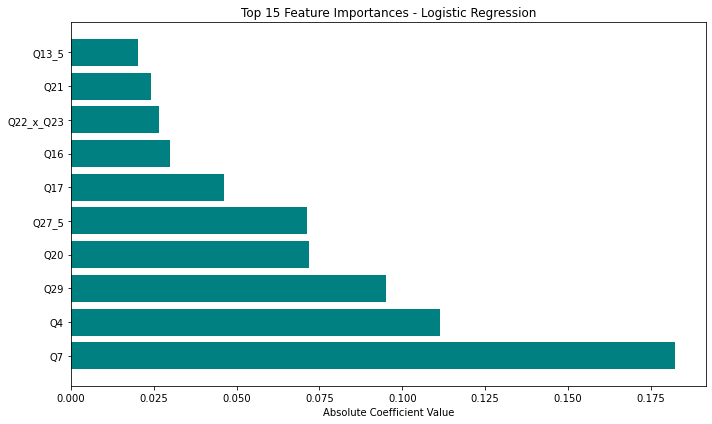

Logistic Regression Results:
Accuracy: 0.5473
Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.54      0.53        71
         1.0       0.57      0.56      0.56        77

    accuracy                           0.55       148
   macro avg       0.55      0.55      0.55       148
weighted avg       0.55      0.55      0.55       148

Confusion Matrix:
[[38 33]
 [34 43]]


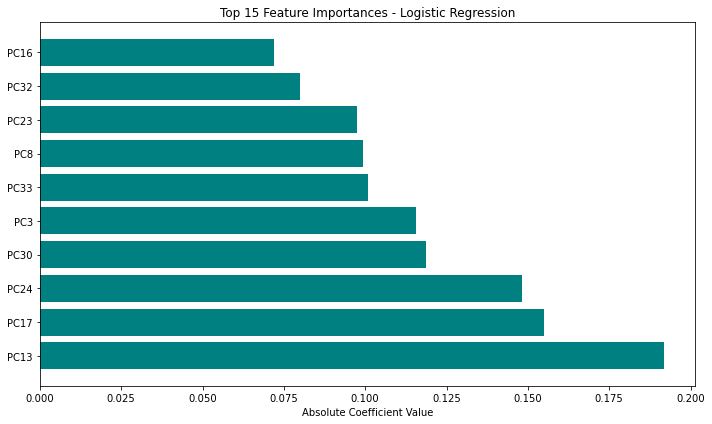

SVM Results:
Accuracy: 0.5608
Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.59      0.56        71
         1.0       0.59      0.53      0.56        77

    accuracy                           0.56       148
   macro avg       0.56      0.56      0.56       148
weighted avg       0.56      0.56      0.56       148

Confusion Matrix:
[[42 29]
 [36 41]]


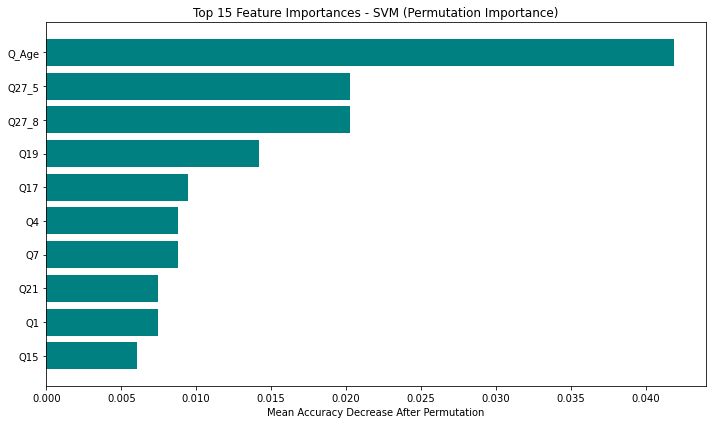

SVM Results:
Accuracy: 0.5541
Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.44      0.48        71
         1.0       0.56      0.66      0.61        77

    accuracy                           0.55       148
   macro avg       0.55      0.55      0.55       148
weighted avg       0.55      0.55      0.55       148

Confusion Matrix:
[[31 40]
 [26 51]]


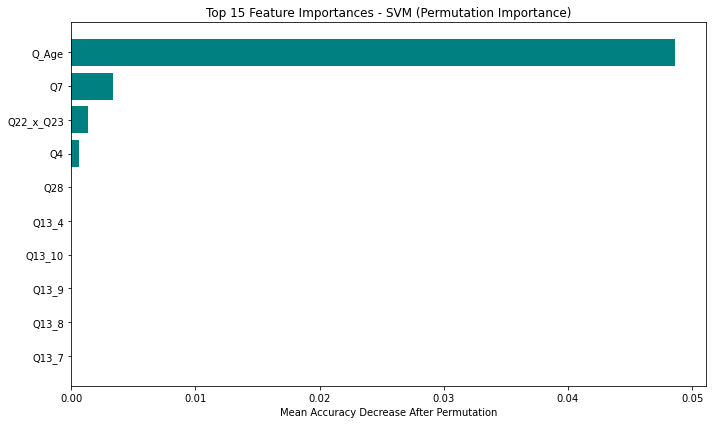

SVM Results:
Accuracy: 0.5743
Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.58      0.57        71
         1.0       0.59      0.57      0.58        77

    accuracy                           0.57       148
   macro avg       0.57      0.57      0.57       148
weighted avg       0.58      0.57      0.57       148

Confusion Matrix:
[[41 30]
 [33 44]]


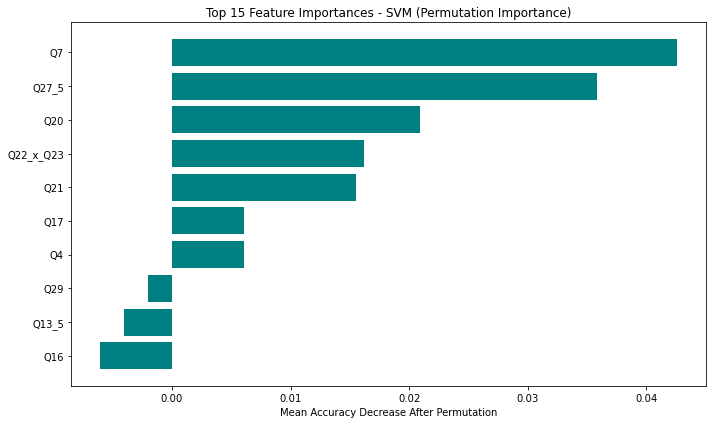

SVM Results:
Accuracy: 0.5676
Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.61      0.57        71
         1.0       0.59      0.53      0.56        77

    accuracy                           0.57       148
   macro avg       0.57      0.57      0.57       148
weighted avg       0.57      0.57      0.57       148

Confusion Matrix:
[[43 28]
 [36 41]]


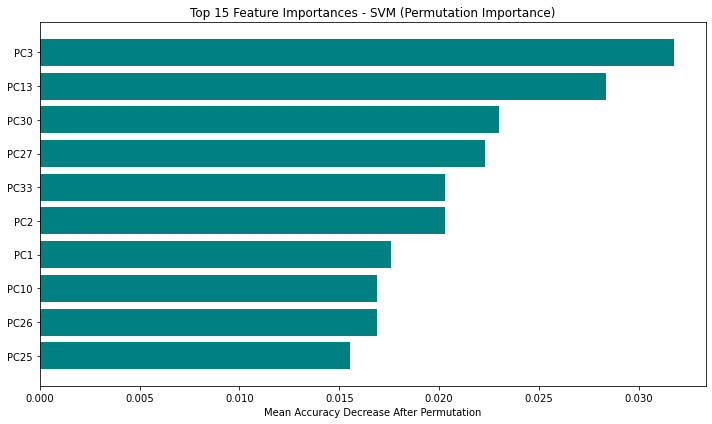

(SVC(class_weight='balanced', probability=True),
 array([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
        0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
        0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
        1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0.]))

In [21]:
def run_logistic_regression(X_train, y_train, X_test, y_test, features=None, 
                          max_iter=100000, solver='saga', C=0.01, class_weight='balanced'):
    
    
    model = LogisticRegression(max_iter=max_iter, solver=solver, 
                             C=C, class_weight=class_weight)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    print('Logistic Regression Results:')
    print(f'Accuracy: {m.accuracy_score(y_test, preds):.4f}')
    print('Classification Report:')
    print(m.classification_report(y_test, preds))
    print('Confusion Matrix:')
    print(m.confusion_matrix(y_test, preds))
    
    # Feature importance plot
    if hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
        feature_names = X_train.columns
        
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.title("Top 15 Feature Importances - Logistic Regression")
        plt.barh(range(10), importances[indices][:10], align='center', color='teal')
        plt.yticks(range(10), feature_names[indices][:10])
        plt.xlabel("Absolute Coefficient Value")
        plt.tight_layout()
        plt.show()
    
    return model, preds

def run_svm(X_train, y_train, X_test, y_test, features=None,
           kernel='rbf', class_weight='balanced', probability=True):
    
    model = SVC(kernel=kernel, class_weight=class_weight, probability=probability)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    print('SVM Results:')
    print(f'Accuracy: {m.accuracy_score(y_test, preds):.4f}')
    print('Classification Report:')
    print(m.classification_report(y_test, preds))
    print('Confusion Matrix:')
    print(m.confusion_matrix(y_test, preds))
    
    # Permutation importance
    result = permutation_importance(
        model, 
        X_test, 
        y_test, 
        n_repeats=10,
        random_state=42
    )
    
    importances = result.importances_mean
    feature_names = X_train.columns
    
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Top 15 Feature Importances - SVM (Permutation Importance)")
    plt.barh(
        feature_names[indices][:10][::-1],
        importances[indices][:10][::-1],
        color='teal'
    )
    plt.xlabel("Mean Accuracy Decrease After Permutation")
    plt.tight_layout()
    plt.show()
    
    return model, preds

run_logistic_regression(X_train, y_train, X_test, y_test, features=None, 
                          max_iter=100000, solver='saga', C=0.01, class_weight='balanced')

run_logistic_regression(X_train_scaled, y_train, X_test_scaled, y_test, features=None, 
                          max_iter=100000, solver='saga', C=0.01, class_weight='balanced')

run_logistic_regression(X_train_domain, y_train, X_test_domain, y_test, features=None, 
                          max_iter=100000, solver='saga', C=0.01, class_weight='balanced')

run_logistic_regression(X_train_pca, y_train, X_test_pca, y_test, features=None, 
                          max_iter=100000, solver='saga', C=0.01, class_weight='balanced')

run_svm(X_train_scaled, y_train, X_test_scaled, y_test, features=None,
           kernel='rbf', class_weight='balanced', probability=True)

run_svm(X_train, y_train, X_test, y_test, features=None,
           kernel='rbf', class_weight='balanced', probability=True)

run_svm(X_train_domain, y_train, X_test_domain, y_test, features=None,
           kernel='rbf', class_weight='balanced', probability=True)

run_svm(X_train_pca, y_train, X_test_pca, y_test, features=None,
           kernel='rbf', class_weight='balanced', probability=True)

Random Forest Classifier
Accuracy: 0.5743
Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.61      0.58        71
         1.0       0.60      0.55      0.57        77

    accuracy                           0.57       148
   macro avg       0.58      0.58      0.57       148
weighted avg       0.58      0.57      0.57       148

Confusion Matrix:
[[43 28]
 [35 42]]


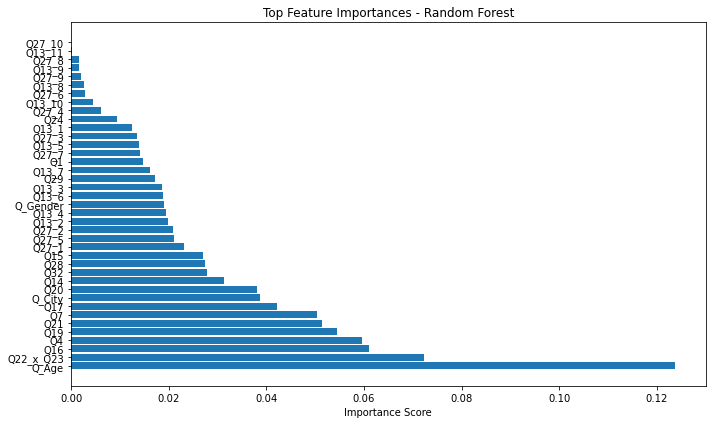

Random Forest Classifier
Accuracy: 0.5541
Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.58      0.55        71
         1.0       0.58      0.53      0.55        77

    accuracy                           0.55       148
   macro avg       0.55      0.55      0.55       148
weighted avg       0.56      0.55      0.55       148

Confusion Matrix:
[[41 30]
 [36 41]]


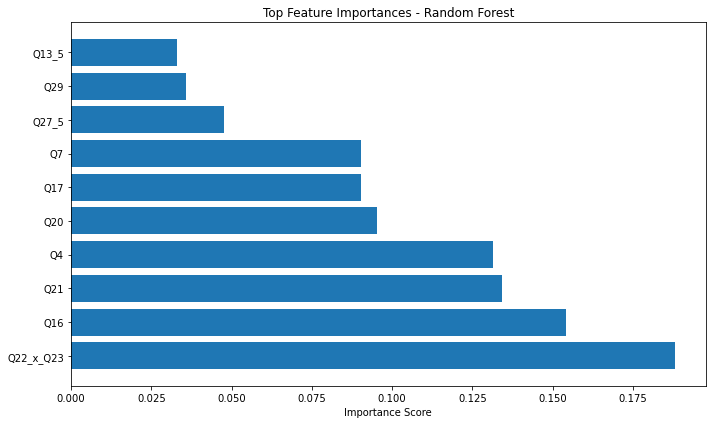

C:\Users\idawh\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [15:35:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier
Accuracy: 0.6081
Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.62      0.60        71
         1.0       0.63      0.60      0.61        77

    accuracy                           0.61       148
   macro avg       0.61      0.61      0.61       148
weighted avg       0.61      0.61      0.61       148

Confusion Matrix:
[[44 27]
 [31 46]]


<Figure size 720x432 with 0 Axes>

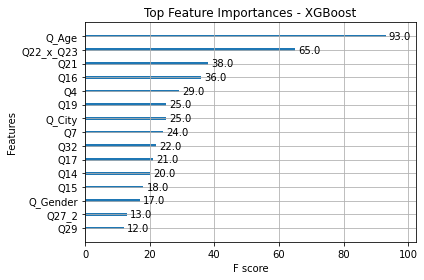

C:\Users\idawh\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [15:35:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier
Accuracy: 0.5405
Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      0.51      0.51        71
         1.0       0.56      0.57      0.56        77

    accuracy                           0.54       148
   macro avg       0.54      0.54      0.54       148
weighted avg       0.54      0.54      0.54       148

Confusion Matrix:
[[36 35]
 [33 44]]


<Figure size 720x432 with 0 Axes>

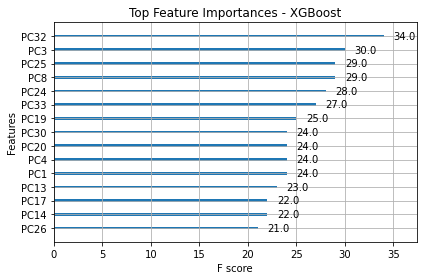

[LightGBM] [Info] Number of positive: 291, number of negative: 297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 588, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

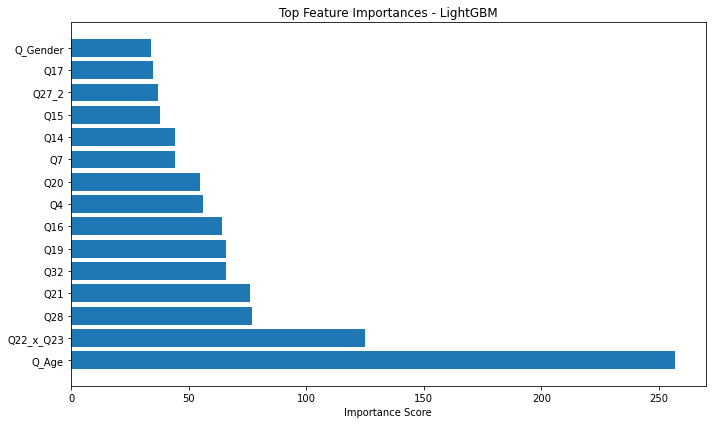

[LightGBM] [Info] Number of positive: 291, number of negative: 297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 588, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

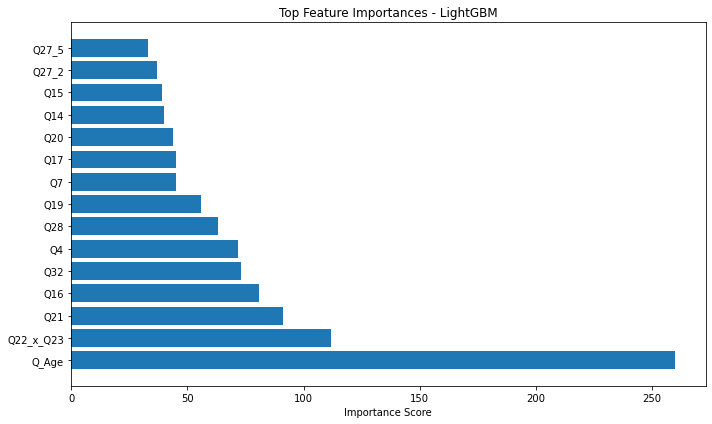

[LightGBM] [Info] Number of positive: 291, number of negative: 297
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6677
[LightGBM] [Info] Number of data points in the train set: 588, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

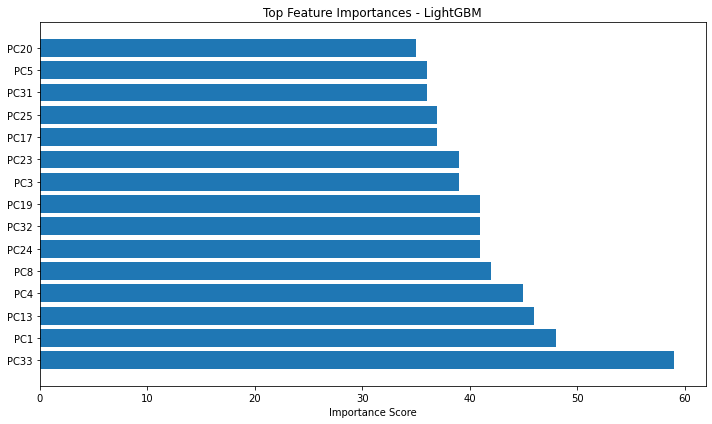

(LGBMClassifier(class_weight='balanced', max_depth=5, random_state=42),
 array([0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
        0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0.]))

In [22]:
#Tree models

def run_random_forest(X_train, y_train, X_test, y_test, features=None,
                     n_estimators=100, max_depth=12, max_features='sqrt',
                     min_samples_leaf=3, min_samples_split=2, random_state=42):
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    print('Random Forest Classifier')
    print(f'Accuracy: {accuracy_score(y_test, preds):.4f}')
    print('Classification Report:')
    print(classification_report(y_test, preds))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, preds))
    
    # Plot Gini importance
    importances = model.feature_importances_
    feature_names = X_train.columns
    sorted_indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Top Feature Importances - Random Forest")
    plt.barh(range(len(feature_names)), importances[sorted_indices], align='center')
    plt.yticks(range(len(feature_names)), feature_names[sorted_indices])
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()
    
    return model, preds

def run_xgboost(X_train, y_train, X_test, y_test, features=None,
               learning_rate=0.1, max_depth=3, min_child_weight=1,
               subsample=0.8, colsample_bytree=0.8, n_estimators=100,
               gamma=0, random_state=42):
    
    model = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        n_estimators=n_estimators,
        gamma=gamma,
        random_state=random_state,
        eval_metric='logloss',
        use_label_encoder=False
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    print('XGBoost Classifier')
    print(f'Accuracy: {accuracy_score(y_test, preds):.4f}')
    print('Classification Report:')
    print(classification_report(y_test, preds))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, preds))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plot_importance(model, max_num_features=15)
    plt.title("Top Feature Importances - XGBoost")
    plt.tight_layout()
    plt.show()
    
    return model, preds

def run_lightgbm(X_train, y_train, X_test, y_test, features=None,
                n_estimators=100, learning_rate=0.1, max_depth=5,
                num_leaves=31, class_weight='balanced', random_state=42):
    
    model = LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        class_weight=class_weight,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    print("LightGBM Results:")
    print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))
    
    # Plot feature importance
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Top Feature Importances - LightGBM")
    plt.barh(range(len(indices[:15])), importances[indices][:15], align='center')
    plt.yticks(range(len(indices[:15])), X_train.columns[indices][:15])
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()
    
    return model, preds

run_random_forest(X_train, y_train, X_test, y_test, features=None,
                     n_estimators=100, max_depth=12, max_features='sqrt',
                     min_samples_leaf=3, min_samples_split=2, random_state=42)

run_random_forest(X_train_domain, y_train, X_test_domain, y_test, features=None,
                     n_estimators=100, max_depth=12, max_features='sqrt',
                     min_samples_leaf=3, min_samples_split=2, random_state=42)


run_xgboost(X_train, y_train, X_test, y_test, features=None,
               learning_rate=0.1, max_depth=3, min_child_weight=1,
               subsample=0.8, colsample_bytree=0.8, n_estimators=100,
               gamma=0, random_state=42)

run_xgboost(X_train_pca, y_train, X_test_pca, y_test, features=None,
               learning_rate=0.1, max_depth=3, min_child_weight=1,
               subsample=0.8, colsample_bytree=0.8, n_estimators=100,
               gamma=0, random_state=42)


run_lightgbm(X_train, y_train, X_test, y_test, features=None,
                n_estimators=100, learning_rate=0.1, max_depth=5,
                num_leaves=31, class_weight='balanced', random_state=42)

run_lightgbm(X_train_scaled, y_train, X_test_scaled, y_test, features=None,
                n_estimators=100, learning_rate=0.1, max_depth=5,
                num_leaves=31, class_weight='balanced', random_state=42)

run_lightgbm(X_train_pca, y_train, X_test_pca, y_test, features=None,
                n_estimators=100, learning_rate=0.1, max_depth=5,
                num_leaves=31, class_weight='balanced', random_state=42)

Index(['Q_City', 'Q4', 'Q7', 'Q13_8', 'Q13_9', 'Q13_11', 'Q14', 'Q16', 'Q17',
       'Q21', 'Q27_3', 'Q27_7', 'Q27_8', 'Q27_9', 'Q27_10'],
      dtype='object')
Random Forest Classifier
0.5608108108108109
              precision    recall  f1-score   support

         0.0       0.54      0.58      0.56        71
         1.0       0.58      0.55      0.56        77

    accuracy                           0.56       148
   macro avg       0.56      0.56      0.56       148
weighted avg       0.56      0.56      0.56       148

[[41 30]
 [35 42]]


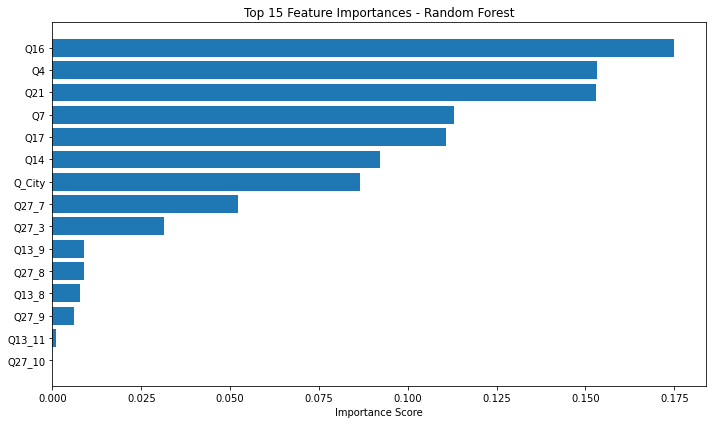

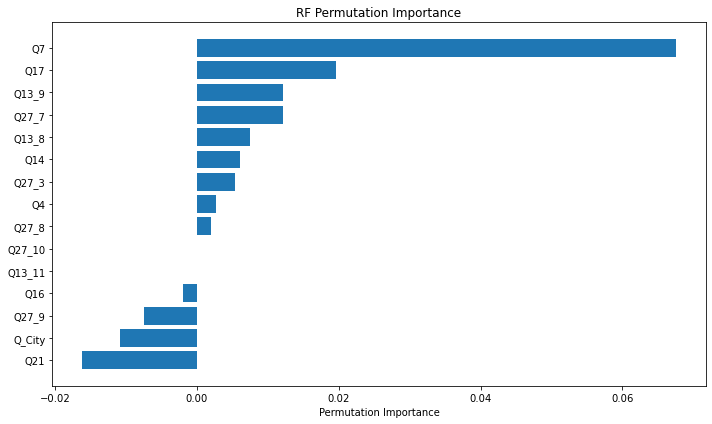

Random Forest Classifier (Top 15 Permutation Features)
0.527027027027027
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'subsample': 0.5, 'n_estimators': 150, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.125, 'colsample_bytree': 0.625}
Best CV accuracy: 0.6002897291032885
              precision    recall  f1-score   support

         0.0       0.59      0.68      0.63        71
         1.0       0.65      0.56      0.60        77

    accuracy                           0.61       148
   macro avg       0.62      0.62      0.61       148
weighted avg       0.62      0.61      0.61       148



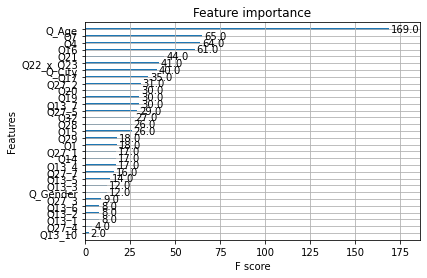

C:\Users\idawh\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [15:36:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier
0.5405405405405406
              precision    recall  f1-score   support

         0.0       0.52      0.56      0.54        71
         1.0       0.56      0.52      0.54        77

    accuracy                           0.54       148
   macro avg       0.54      0.54      0.54       148
weighted avg       0.54      0.54      0.54       148

[[40 31]
 [37 40]]


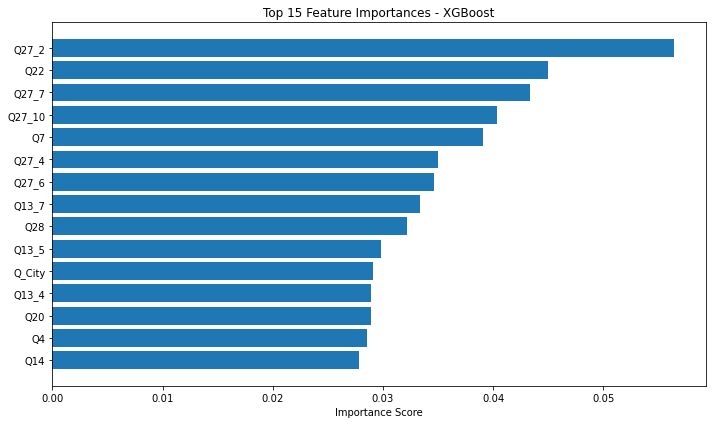

[LightGBM] [Info] Number of positive: 291, number of negative: 297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 56
[LightGBM] [Info] Number of data points in the train set: 588, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

ImportError: numpy.core.multiarray failed to import

In [23]:
#-----------------------------------------TREE-BASED MODELS-----------------------------------------------------------------

#-----------------------------------------RANDOM FOREST------------------------------------------------------------------------
#param_grid = {
#    'n_estimators': [100, 300],
 #   'max_depth': [3, 5],
 #   'min_samples_split': [2, 5],
 #   'min_samples_leaf': [1, 3],
  #  'max_features': ['sqrt', 'log2']
#}

rf_model = RandomForestClassifier(
    random_state=42,
    max_depth=12,
    max_features='sqrt',
    min_samples_leaf=3,
    min_samples_split=2,
    n_estimators=100
)
rf_model.fit(X_train_top15, y_train)
rf_preds = rf_model.predict(X_test_top15)
print(X_train_top15.columns)
print('Random Forest Classifier')
print(m.accuracy_score(y_test,rf_preds))
print(m.classification_report(y_test,rf_preds))
print(m.confusion_matrix(y_test,rf_preds))
#print("Best RF Params:", rf_model.best_params_)

# Plot feature importance
importances = rf_model.feature_importances_
feature_names = X_train_top15.columns
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - Random Forest")
plt.barh(feature_names[sorted_indices][::-1], importances[sorted_indices][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Calculate permutation importance
result = permutation_importance(rf_model, X_test_top15, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_sorted_idx = result.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("RF Permutation Importance")
plt.barh(X_test_top15.columns[perm_sorted_idx][::-1], result.importances_mean[perm_sorted_idx][::-1])
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.show()

top15_perm_features = X_test_top15.columns[perm_sorted_idx].tolist()
# Select those features from train and test sets
X_train_top15_perm = X_train_top15[top15_perm_features]
X_test_top15_perm = X_test_top15[top15_perm_features]
rf_model1 = RandomForestClassifier(random_state=42)
rf_model1.fit(X_train_top15_perm, y_train)
y_pred1 = rf_model1.predict(X_test_top15_perm)
print('Random Forest Classifier (Top 15 Permutation Features)')
print(m.accuracy_score(y_test, y_pred1))

#---------------------------------------XGBoost--------------------------------------------------------------------------------
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=100, objective='binary:logistic')

param_dist = {
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': np.arange(3, 10),
    'min_child_weight': np.arange(1, 6),
    'subsample': np.linspace(0.5, 1.0, 5),
    'colsample_bytree': np.linspace(0.5, 1.0, 5),
    'n_estimators': np.arange(50, 300, 50),
    'gamma': np.linspace(0, 0.5, 5),
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,           # Number of random combinations to try
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=100
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)

best_xgb = random_search.best_estimator_

# Predict on test set
y_pred = best_xgb.predict(X_test)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Feature importance
import matplotlib.pyplot as plt
from xgboost import plot_importance
plot_importance(best_xgb)
plt.show()


xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print('XGBoost Classifier')
print(m.accuracy_score(y_test,xgb_preds))
print(m.classification_report(y_test,xgb_preds))
print(m.confusion_matrix(y_test,xgb_preds))

# Plot feature importance
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - XGBoost")
plt.barh(X.columns[indices][:15][::-1], importances[indices][:15][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

#-----------------------------------------LIGHTGBM-----------------------------------------------------------------------------

from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Use top features from feature selection if you want
# X_train_selected = X_train_scaled[top_15_features]

lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    num_leaves=31,
    class_weight='balanced',  # handles imbalance like in LogisticRegression
    random_state=42
)

lgbm_model.fit(X_train_top15, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_top15)

# Evaluation
print("LightGBM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))
print(confusion_matrix(y_test, y_pred_lgbm))

#-----------------------------------------CATBOOST-----------------------------------------------------------------------------
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt

# Load data (replace with your data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize CatBoost
catboost_model = CatBoostClassifier(
    random_seed=42,
    verbose=0,  # Set to 1 for training logs
    auto_class_weights='Balanced'  # Handles class imbalance
)

# Define hyperparameter grid for tuning
param_grid = {
    'iterations': [100, 200, 300],          # Number of trees
    'depth': [4, 6, 8],                     # Tree depth
    'learning_rate': [0.01, 0.05, 0.1],     # Step size
    'l2_leaf_reg': [1, 3, 5],               # Regularization
    'border_count': [32, 64, 128]           # Splits for numerical features
}

# RandomizedSearchCV for tuning
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    n_iter=20,                              # Number of random combinations
    cv=5,                                   # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters:", random_search.best_params_)
best_cb = random_search.best_estimator_

# Predictions
y_pred = best_cb.predict(X_test)

# Evaluation
print("\nCatBoost Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance
feature_importance = best_cb.get_feature_importance()
feature_names = X_train.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.title("CatBoost Feature Importance")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for a more professional look
sns.set_style("white")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']

# Collect all importance data (using your existing variable names)
importance_data = {
    'Logistic Regression': pd.Series(np.abs(model.coef_[0]), index=X_train_scaled.columns),
    'SVM': pd.Series(result.importances_mean, index=X_train_scaled.columns),
    'Random Forest': pd.Series(rf_model.feature_importances_, index=X_train_top15.columns),
    'XGBoost': pd.Series(xgb_model.feature_importances_, index=X_train.columns)
}

# Normalize each importance to 0-1 range
normalized_importances = {}
for model_name, importance in importance_data.items():
    normalized = (importance - importance.min()) / (importance.max() - importance.min())
    normalized_importances[model_name] = normalized.sort_values(ascending=False)

# Get top 15 features from each model (increased from 10)
top_features = set()
for model_name, importance in normalized_importances.items():
    top_features.update(importance.head(15).index)

# Create comparison DataFrame
comparison_df = pd.DataFrame(index=list(top_features))
for model_name, importance in normalized_importances.items():
    comparison_df[model_name] = importance

# Fill NaN values with 0
comparison_df = comparison_df.fillna(0)

# Sort by average importance across models
comparison_df['Average'] = comparison_df.mean(axis=1)
comparison_df = comparison_df.sort_values('Average', ascending=False).head(15)

# Choose a more appealing color palette
colors = ['#647D65', '#F0D0DB', '#325E71', '#6B3842']  # Blue, Red, Green, Purple

# Create the plot with enhanced aesthetics
fig, ax = plt.subplots(figsize=(14, 10))

# Plot the bars
comparison_df.drop('Average', axis=1).plot.barh(
    ax=ax,
    color=colors,
    width=0.75,
    edgecolor='white',
    linewidth=0.5
)

# Customize the plot
ax.set_title('Feature Importance Comparison Across Models', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Normalized Importance Score (0-1)', fontsize=14, labelpad=10)
ax.set_ylabel('Features', fontsize=14, labelpad=10)

# Enhanced legend - MOVED TO TOP RIGHT
legend = ax.legend(
    title='Models',
    title_fontsize=14,
    fontsize=12,
    frameon=True,
    facecolor='white',
    edgecolor='#CCCCCC',
    loc='upper right',  # Changed from 'lower right' to 'upper right'
    bbox_to_anchor=(1, 1)  # Changed from (1, 0) to (1, 1)
)
legend.get_frame().set_alpha(0.9)

# Add grid only on x-axis with light gray color
ax.grid(axis='x', color='#E6E6E6', linestyle='-', linewidth=0.5, alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)

# Add a subtle border to the figure
fig.patch.set_linewidth(1)
fig.patch.set_edgecolor('#DDDDDD')

# Add values at the end of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

# Add a subtle box around the plot
plt.box(on=True)

# Tight layout
plt.tight_layout()

# Add a small caption at the bottom
plt.figtext(0.5, 0.01, 'Comparing normalized feature importance scores across machine learning models', 
            ha='center', fontsize=10, color='#666666')

# Display the plot
plt.show()

# Create a heatmap version as an alternative visualization
plt.figure(figsize=(14, 10))
sns.heatmap(comparison_df.drop('Average', axis=1), 
            cmap='viridis', 
            annot=True, 
            fmt='.2f',
            linewidths=.5,
            cbar_kws={'label': 'Normalized Importance'})

plt.title('Feature Importance Heatmap Across Models', fontsize=18, fontweight='bold', pad=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


----- Naive Bayes Results -----
Accuracy: 0.5357

Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.32      0.41        85
         1.0       0.52      0.76      0.62        83

    accuracy                           0.54       168
   macro avg       0.55      0.54      0.51       168
weighted avg       0.55      0.54      0.51       168



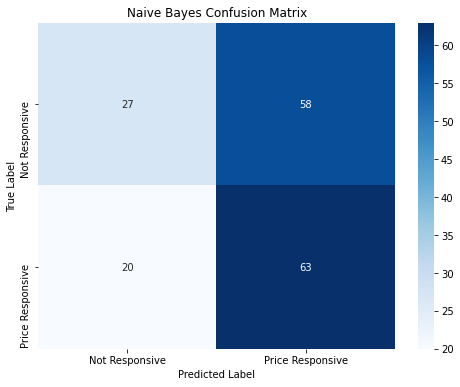

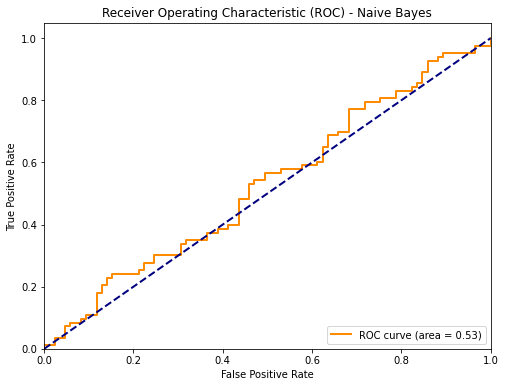

Cross-validation scores: [0.53333333 0.52238806 0.58208955 0.52985075 0.52238806]
Mean CV accuracy: 0.5380
Standard deviation: 0.0224


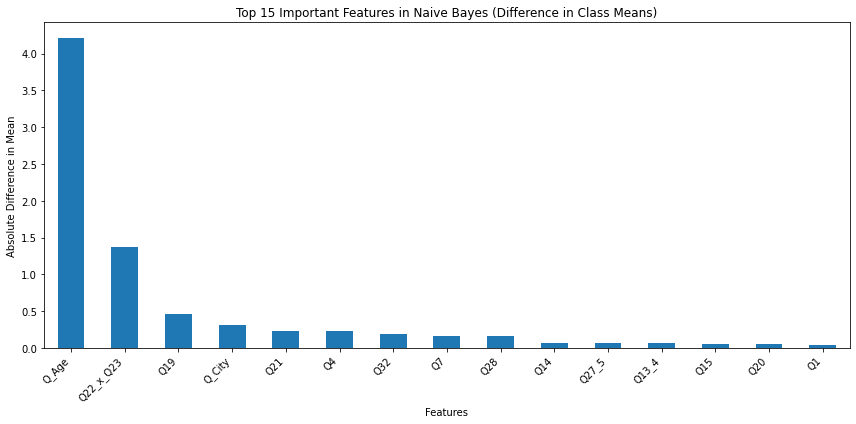

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 194, in _get_response_values
    y_pred = prediction_method(X)
  File "C:\Users\idawh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 266, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\i

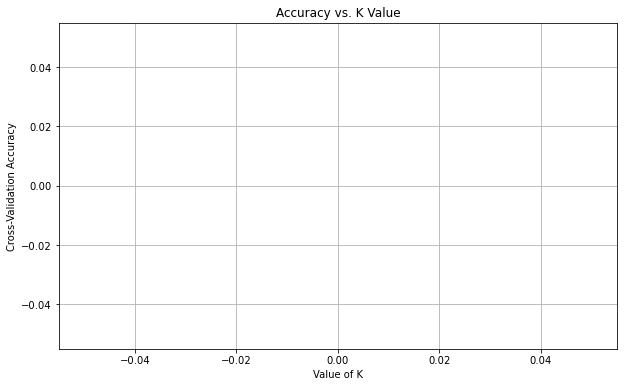


Best K value: 1
Best parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}


C:\Users\idawh\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [20]:
# Naive Bayes Implementation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, GridSearchCV

# -------------------- NAIVE BAYES MODEL --------------------
# Initialize the model

# Calculate class ratios (74 Class 1.0 vs. 64 Class 0.0)
class_ratio = 64 / 74  # ~0.86
nb_model = GaussianNB(priors=[0.5, 0.5])

# Train the model using the selected features from forward selection
nb_model.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test)
y_prob_nb = nb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"\n----- Naive Bayes Results -----")
print(f"Accuracy: {nb_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Responsive', 'Price Responsive'],
            yticklabels=['Not Responsive', 'Price Responsive'])
plt.title('Naive Bayes Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Naive Bayes')
plt.legend(loc="lower right")
plt.show()

# Cross-validation for Naive Bayes
cv_scores_nb = cross_val_score(nb_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores_nb}")
print(f"Mean CV accuracy: {np.mean(cv_scores_nb):.4f}")
print(f"Standard deviation: {np.std(cv_scores_nb):.4f}")

# Feature importance analysis for Naive Bayes
# Get class conditional means for all features (not just top 15)
class_means = pd.DataFrame(
    nb_model.theta_,
    columns=X_train.columns  # Use original feature names
)
class_means.index = ['Not Responsive', 'Price Responsive']

# Calculate absolute difference in means between classes
feature_importance = abs(class_means.iloc[1] - class_means.iloc[0])
feature_importance = feature_importance.sort_values(ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 6))
feature_importance.head(15).plot(kind='bar')  # Only plot top 15
plt.title('Top 15 Important Features in Naive Bayes (Difference in Class Means)')
plt.xlabel('Features')
plt.ylabel('Absolute Difference in Mean')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# -------------------- KNN MODEL --------------------
# Find optimal K using cross-validation
k_range = range(1, 31)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    k_scores.append(np.mean(scores))

# Plot the cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Accuracy vs. K Value')
plt.grid(True)
plt.show()

# Get best K value
best_k = k_range[np.argmax(k_scores)]
print(f"\nBest K value: {best_k}")

# Fine-tune KNN with GridSearchCV
param_grid = {
    'n_neighbors': [best_k-2, best_k-1, best_k, best_k+1, best_k+2] if best_k > 2 else [1, 2, 3, 4],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Create and train the optimal KNN model
knn_model = KNeighborsClassifier(**best_params)
knn_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test_scaled)
y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"\n----- KNN Results -----")
print(f"Accuracy: {knn_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Responsive', 'Price Responsive'],
            yticklabels=['Not Responsive', 'Price Responsive'])
plt.title('KNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - KNN')
plt.legend(loc="lower right")
plt.show()

# Cross-validation for final KNN model
cv_scores_knn = cross_val_score(knn_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores_knn}")
print(f"Mean CV accuracy: {np.mean(cv_scores_knn):.4f}")
print(f"Standard deviation: {np.std(cv_scores_knn):.4f}")

# -------------------- MODEL COMPARISON --------------------
# Compare the performance of both models
models = ['Naive Bayes', 'KNN']
accuracies = [nb_accuracy, knn_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies)
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()

# Plot ROC curves for both models
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, 'b-', lw=2, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_knn, tpr_knn, 'r-', lw=2, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:

#---------------------------------------------------------INFORMATION GAIN-----------------------------------------------------

from sklearn.feature_selection import mutual_info_classif

n = 15
n_neighbors = 5
base_random_state = 42

mi_scores = np.zeros((n, X.shape[1]))

for i in range(n):
    mi_scores[i] = mutual_info_classif(
        X, y,
        n_neighbors=n_neighbors,
        random_state=base_random_state + i 
    )
    
stable_mi = pd.Series(mi_scores.mean(axis=0), index=X.columns)

stable_mi = stable_mi[stable_mi > 0.001] 

plt.figure(figsize=(10, 6))
ax = stable_mi.sort_values().plot(
    kind='barh', 
    color='teal', 
    alpha=0.7
)

for i in ax.patches:
    ax.text(
        i.get_width() + 0.001, 
        i.get_y() + 0.1,
        f'{i.get_width():.4f}',  # Format to 4 decimal places
        fontsize=10
    )

plt.title('Stable Feature Importance (Mutual Information)', pad=20, fontsize=14)
plt.xlabel('Mutual Information Score', labelpad=10)
plt.ylabel('Features', labelpad=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

N = 20  # Adjust as needed
top_features = stable_mi.nlargest(N).index.tolist()
print(f"Top {N} stable features:", top_features)

print("=== Sorted Feature Importance ===")
print(stable_mi.sort_values(ascending=False).round(4).to_string())  # 4 decimal places
print("\n")


#---------------------------------------------------------FORWARD SELECTION-----------------------------------------------------


model = LogisticRegression(max_iter=10000, solver='saga', C=0.1,class_weight='balanced')

sfs = SFS(model, k_features=15, forward=True, floating=False, scoring="accuracy", cv=5)

sfs.fit(X_train_scaled, y_train)

selected_features = list(sfs.k_feature_names_)

X_train_top15 = X_train_scaled[selected_features]
X_test_top15 = X_test_scaled[selected_features]

#print("Selected Features:", sfs.k_feature_names_)

accuracy = sfs.k_score_
print("Accuracy:", accuracy)

sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df["avg_score"] = sfs_df["avg_score"].astype(float)
fig, ax = plt.subplots()
sfs_df.plot(kind="line", y="avg_score", ax=ax)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title("Forward Selection Performance")
plt.show()

#-------------------------------------------------FEATURE IMPORTANCE-----------------------------------------------------------

#LOGISTICAL REGRESSION-------------------------------------------------------------

from sklearn.metrics import precision_recall_curve

model=LogisticRegression(max_iter=10000, solver='saga', C=0.01,class_weight='balanced')
model.fit(X_train_scaled,y_train)

label_pred_LR=model.predict(X_test_scaled)

print('Logistic regression')
print(m.accuracy_score(y_test,label_pred_LR))
print(m.classification_report(y_test,label_pred_LR))
print(m.confusion_matrix(y_test,label_pred_LR))

from sklearn.inspection import permutation_importance

importances = np.abs(model.coef_[0])  # Use [0] for binary classification
feature_names = X_train_scaled.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - Logistic Regression")
plt.barh(range(15), importances[indices][:15], align='center', color='teal')
plt.yticks(range(15), feature_names[indices][:15])
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=10000, solver='saga', class_weight='balanced'), 
                    param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

print("Best C:", grid.best_params_)

#RANDOM FOREST------------------------------------------------------------------------
#param_grid = {
#    'n_estimators': [100, 300],
 #   'max_depth': [3, 5],
 #   'min_samples_split': [2, 5],
 #   'min_samples_leaf': [1, 3],
  #  'max_features': ['sqrt', 'log2']
#}

rf_model = RandomForestClassifier(
    random_state=42,
    max_depth=12,
    max_features='sqrt',
    min_samples_leaf=3,
    min_samples_split=2,
    n_estimators=100
)


rf_model.fit(X_train_top15, y_train)
rf_preds = rf_model.predict(X_test_top15)

print('Random Forest Classifier')
print(m.accuracy_score(y_test,rf_preds))
print(m.classification_report(y_test,rf_preds))
print(m.confusion_matrix(y_test,rf_preds))
#print("Best RF Params:", rf_model.best_params_)

# Plot feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - Random Forest")
plt.barh(X.columns[indices][:15][::-1], importances[indices][:15][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

from sklearn.inspection import permutation_importance

result = permutation_importance(rf_model, X_test_top15, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.barh(X_test_top15.columns[sorted_idx][:15][::-1], result.importances_mean[sorted_idx][:15][::-1])
plt.xlabel("Permutation Importance")
plt.title("RF Permutation Importance")
plt.tight_layout()
plt.show()

cols = list(X_train_scaled.columns)
cols.remove('Q7')
cols = ['Q7'] + cols  # move Q7 to the front

X_train_top15_reordered = X_train_scaled[cols]
X_test_top15_reordered = X_test_scaled[cols]

rf_model1 = RandomForestClassifier(random_state=42)
rf_model1.fit(X_train_top15_reordered, y_train)
y_pred1 = rf_model1.predict(X_test_top15_reordered)

print('Random Forest Classifier')
print(m.accuracy_score(y_test,y_pred1))
print(m.classification_report(y_test,y_pred1))
print(m.confusion_matrix(y_test,y_pred1))

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - Random Forest")
plt.barh(X.columns[indices][:15][::-1], importances[indices][:15][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

#XGBoost--------------------------------------------------------------------------------
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_preds = xgb_model.predict(X_test_scaled)

print('XGBoost Classifier')
print(m.accuracy_score(y_test,xgb_preds))
print(m.classification_report(y_test,xgb_preds))
print(m.confusion_matrix(y_test,xgb_preds))

# Plot feature importance
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - XGBoost")
plt.barh(X.columns[indices][:15][::-1], importances[indices][:15][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

svm = SVC(kernel='rbf', class_weight='balanced', probability=True)
svm.fit(X_train_scaled, y_train)

svm_preds = svm.predict(X_test_scaled)

print('SVM')
print(m.accuracy_score(y_test,svm_preds))
print(m.classification_report(y_test,svm_preds))
print(m.confusion_matrix(y_test,svm_preds))

result = permutation_importance(
    svm, 
    X_test_scaled,  # Use test data to avoid bias
    y_test, 
    n_repeats=10,    # Number of shuffles per feature
    random_state=42
)

# Get feature importances and names
importances = result.importances_mean
feature_names = X.columns  # Original column names before scaling

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot top 15 features
plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - SVM (Permutation Importance)")
plt.barh(
    feature_names[indices][:15][::-1],  # Show least important at top
    importances[indices][:15][::-1],
    color='teal'
)
plt.xlabel("Mean Accuracy Decrease After Permutation")
plt.tight_layout()
plt.show()

#LIGHTGBM-----------------------------------------------------------------------------

from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Use top features from feature selection if you want
# X_train_selected = X_train_scaled[top_15_features]

lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    num_leaves=31,
    class_weight='balanced',  # handles imbalance like in LogisticRegression
    random_state=42
)

lgbm_model.fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# Evaluation
print("LightGBM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))
print(confusion_matrix(y_test, y_pred_lgbm))


# Neural network
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)
nn.fit(X_train_scaled, y_train)

nn_preds = nn.predict(X_test_scaled)

print('MLPC')
print(m.accuracy_score(y_test,nn_preds))
print(m.classification_report(y_test,nn_preds))
print(m.confusion_matrix(y_test,nn_preds))

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('xgb', XGBClassifier()),
    ('svc', SVC(probability=True))
]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train_scaled, y_train)

label_pred_LR=clf.predict(X_test_scaled)

print('Logistic regression')
print(m.accuracy_score(y_test,label_pred_LR))
print(m.classification_report(y_test,label_pred_LR))
print(m.confusion_matrix(y_test,label_pred_LR))


In [ ]:
#-----------------------------------------------------------FISHER SCORE-------------------------------------------------------

def manual_fisher_score(X, y):
    """
    Compute true Fisher Scores (not ranks) for features.
    Returns continuous values where higher = more important.
    """
    X = np.array(X)
    y = np.array(y)
    classes = np.unique(y)
    scores = []
    
    for feature in X.T:  # Loop through each feature
        overall_mean = np.mean(feature)
        
        # Between-class variance (numerator)
        between_var = sum(
            [np.sum(y == cls) * (np.mean(feature[y == cls]) - overall_mean)**2 
            for cls in classes])
        
        # Within-class variance (denominator)
        within_var = sum([np.var(feature[y == cls]) * np.sum(y == cls) for cls in classes])
        
        # Avoid division by zero
        fisher_score = between_var / (within_var + 1e-9)
        scores.append(fisher_score)
    
    return np.array(scores)

# Usage:
ranks = manual_fisher_score(X, y)

# Create DataFrame with TRUE Fisher Scores
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Fisher_Score': ranks  # Now using manual scores
}).sort_values('Fisher_Score', ascending=False)

# Add percentile rank to show relative importance
feature_importance['Percentile'] = (
    feature_importance['Fisher_Score'].rank(pct=True).round(2) * 100
)

print("Top 20 Features with TRUE Fisher Scores:")
print(feature_importance.head(20))

In [ ]:
feature_selector = SequentialFeatureSelector(
    estimator=RandomForestClassifier(n_jobs=1, random_state=42),
    k_features=(2, 4),
    forward=True,  # or False for backward selection
    scoring='roc_auc',
    cv=2,
    floating=False,
    verbose=2
)

features = feature_selector.fit(np.array(X_train.fillna(0)), y_train)

# Get the selected feature names
filtered_features = X_train.columns[list(features.k_feature_idx_)]
print("Selected Features:", filtered_features)

# Train the classifier using the selected features
clf = RandomForestClassifier(n_estimators=100, random_state=41, max_depth=3)
clf.fit(X_train[filtered_features].fillna(0), y_train)

# Predict on train and test sets
train_pred = clf.predict_proba(X_train[filtered_features].fillna(0))[:, 1]
test_pred = clf.predict_proba(X_test[filtered_features].fillna(0))[:, 1]

# Evaluate using ROC AUC
print('ROC AUC on training set: {:.4f}'.format(roc_auc_score(y_train, train_pred)))
print('ROC AUC on test set: {:.4f}'.format(roc_auc_score(y_test, test_pred)))

#-----------------------------------------------------Exahaustive feature selection--------------------------------------------

from sklearn.feature_selection import RFECV

# Use cross-validation to determine the best number of features
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=10,                   # 5-fold cross-validation
    scoring='accuracy',      # Use 'r2' for regression
    min_features_to_select=1,
    verbose=1
)

rfecv.fit(X_train_scaled, y_train)

# Results

# Plot feature performance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel("Number of Features Selected")
plt.ylabel("Mean CV Score (Accuracy)")
plt.title("RFECV Performance")
plt.show()

In [ ]:
survey_data = pd.read_csv('answers.csv')

print(survey_data.head())

print(survey_data.shape)

nan_columns = survey_data.columns[survey_data.isna().any()].tolist()

print("Columns with NaN values:", nan_columns)

from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit ONLY on train
X_test_scaled = scaler.transform(X_test)  

d = preprocessing.normalize(X)
scaled_df = pd.DataFrame(d, columns=X.columns)

print(scaled_df)

X = scaled_df

In [ ]:
Age?
Gender?
City?
Q4 Did you monitor your power consumption this winter?
#How did you acquire information about your power consumption?
#Why did you not monitor your consumption?
Did you monitor the variation in electricity prices from day to day and hour to hour this winter?
#How did you acquire information about the electricity prices?
#Why did you not monitor the electricity prices?
Q7 Did you take any measures to decrease or move power consumption from hours with high prices this winter?
#Which measure did you implement?
#Do you know how much the household has saved on the power bill as a result of the measures?
#About how much has the household saved per month this winter as a result of the measures?
#Do you feel that the measures you implemented were worth the savings on the power bill?
#Why did you not take any measures?
What motivates you to reduce your power consumption in high price hours?
How much do you agree or disagree with the following statement? People who adjust their power consumption based on price should be able to save on their power bill.
Would you or have you used a free information service that alerts you of high price hours the following day?
Q16 How many persons does your household consist of, including yourself?
What age are the inhabitants of you household, including yourself?
#Imagine you can buy smart devices for 5,000 NOK that will reduce your power bill by automatically shifting parts of you consumption away from high price hours - without reducing comfort. How much would you have to save every year to do it?
How many weekdays (Mon-Fri) on average was there anyone home in the day (9 a.m. to 4 p.m.) this winter (Nov-Mar)?
What is the highest education in the household?
What is the combined gross income of the household?
What type of residence do you live in?
How big is the residence?
Do you own the residence?
#Do you have a rental unit in the residence?
#Does the rental unit have its own power meter?
Q27 How is the residence heated?
How is the tap water heated?
Do you own one or more electric car that is at least sometimes charged at home?
#How is the car or cars normally charged?
#Do you control the car charging to avoid hours with high prices?
What type of power contract do you have?


#35 spørsmål emn det er 107 kolonner i dataen?

In [ ]:
# SVM with RBF kernel
from sklearn.svm import SVC
svm = SVC(kernel='rbf', class_weight='balanced', probability=True)
svm.fit(X_train, y_train)

svm_preds = svm.predict(X_test)

print('SVM')
print(m.accuracy_score(y_test,svm_preds))
print(m.classification_report(y_test,svm_preds))
print(m.confusion_matrix(y_test,svm_preds))

# Neural network
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)
nn.fit(X_train, y_train)

nn_preds = nn.predict(X_test)

print('NN')
print(m.accuracy_score(y_test,nn_preds))
print(m.classification_report(y_test,nn_preds))
print(m.confusion_matrix(y_test,nn_preds))

In [ ]:
#WEIGHTS

df = pd.read_csv('survey_PE.csv')

#CLASSIFICATION

threshold = -0.06

df['is_price_responsive'] = df['Price_elasticity'].apply(
    lambda x: 1 if x < threshold else 0
)
df = df.dropna(subset=['is_price_responsive'])

df['sample_weight'] = abs(df['Price_elasticity'] - threshold)
df['sample_weight'] = df['sample_weight'] * (len(df) / df['sample_weight'].sum())

print("\nSample weight summary:")
print(df['sample_weight'].describe())

counts = df['is_price_responsive'].value_counts()

print("Counts of each class:")
print(counts)

#X = df.drop(columns=["ID","Price_elasticity", "is_price_responsive"])
#y = df['is_price_responsive']


X = df.drop(columns=["ID", "Price_elasticity", "is_price_responsive", "sample_weight"])
y = df['is_price_responsive']
sample_weights = df['sample_weight']

#print((df == 0).all()) check for columns containing only 0
#one-hot encoding not necessary

#--------------------------------------------------FEATURE SCALING (normalization)---------------------------------------------

d = preprocessing.normalize(X)
scaled_df = pd.DataFrame(d, columns=X.columns)

print(scaled_df)

X = scaled_df

#---------------------------------------------------------INFORMATION GAIN-----------------------------------------------------

from sklearn.feature_selection import mutual_info_classif

importance = mutual_info_classif(X,y)
feat_importance = pd.Series(importance, X.columns)

feat_importance = feat_importance[feat_importance > 0] 


ax = feat_importance.plot(kind='barh', color='teal', alpha=0.7)

# Add value labels to each bar
for i in ax.patches:
    ax.text(i.get_width() + 0.001, i.get_y() + 0.1, 
            f'{i.get_width():.4f}',  # Format to 4 decimal places
            fontsize=10)
    
plt.title('Feature Importance using Mutual Information', pad=20, fontsize=14)
plt.xlabel('Mutual Information Score', labelpad=10)
plt.ylabel('Features', labelpad=10)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

N = 20  # You can change this!
top_features = feat_importance.head(N).index.tolist()


#---------------------------------------------------------FORWARD SELECTION-----------------------------------------------------
X_train, X_test, y_train, y_test, sample_weights_train, sample_weights_test = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42
)

model = LogisticRegression()

sfs = SFS(model, k_features=20, forward=True, floating=False, scoring="accuracy", cv=5)

sfs.fit(X_train, y_train)

#print("Selected Features:", sfs.k_feature_names_)

accuracy = sfs.k_score_
print("Accuracy:", accuracy)

sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df["avg_score"] = sfs_df["avg_score"].astype(float)
fig, ax = plt.subplots()
sfs_df.plot(kind="line", y="avg_score", ax=ax)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title("Forward Selection Performance")
plt.show()

#-----------------------------------------------------Exahaustive feature selection--------------------------------------------
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score


#-------------------------------------------------FEATURE IMPORTANCE-----------------------------------------------------------

#LOGISTICAL REGRESSION-------------------------------------------------------------

from sklearn.metrics import precision_recall_curve

model=LogisticRegression(class_weight='balanced')
model.fit(X_train,y_train, sample_weight=sample_weights_train)

label_pred_LR=model.predict(X_test)

print('Logistic regression')
print(m.accuracy_score(y_test,label_pred_LR))
print(m.classification_report(y_test,label_pred_LR))
print(m.confusion_matrix(y_test,label_pred_LR))

from sklearn.inspection import permutation_importance

importances = np.abs(model.coef_[0])  # Use [0] for binary classification
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - Logistic Regression")
plt.barh(range(15), importances[indices][:15], align='center', color='teal')
plt.yticks(range(15), feature_names[indices][:15])
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

#RANDOM FOREST------------------------------------------------------------------------
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train, sample_weight=sample_weights_train)
rf_preds = rf_model.predict(X_test)

print('Random Forest Classifier')
print(m.accuracy_score(y_test,rf_preds))
print(m.classification_report(y_test,rf_preds))
print(m.confusion_matrix(y_test,rf_preds))

# Plot feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - Random Forest")
plt.barh(X.columns[indices][:15][::-1], importances[indices][:15][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

#XGBoost--------------------------------------------------------------------------------
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train, sample_weight=sample_weights_train)
xgb_preds = xgb_model.predict(X_test)

print('XGBoost Classifier')
print(m.accuracy_score(y_test,xgb_preds))
print(m.classification_report(y_test,xgb_preds))
print(m.confusion_matrix(y_test,xgb_preds))

# Plot feature importance
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - XGBoost")
plt.barh(X.columns[indices][:15][::-1], importances[indices][:15][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# SVM with RBF kernel
from sklearn.svm import SVC
svm = SVC(kernel='rbf', class_weight='balanced', probability=True)
svm.fit(X_train, y_train)

svm_preds = svm.predict(X_test)

print('XGBoost Classifier')
print(m.accuracy_score(y_test,svm_preds))
print(m.classification_report(y_test,svm_preds))
print(m.confusion_matrix(y_test,svm_preds))

# Neural network
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)
nn.fit(X_train, y_train)

nn_preds = nn.predict(X_test)

print('XGBoost Classifier')
print(m.accuracy_score(y_test,nn_preds))
print(m.classification_report(y_test,nn_preds))
print(m.confusion_matrix(y_test,nn_preds))


from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('xgb', XGBClassifier()),
    ('svc', SVC(probability=True))
]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train, sample_weight=sample_weights_train)

label_pred_LR=clf.predict(X_test)

print('Logistic regression')
print(m.accuracy_score(y_test,label_pred_LR))
print(m.classification_report(y_test,label_pred_LR))
print(m.confusion_matrix(y_test,label_pred_LR))
